In [111]:
import numpy as np
from tfld import tfld, utils
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.stats import norm, multivariate_normal

from joblib import Parallel, delayed
from tqdm import tqdm

%matplotlib inline
# %matplotlib notebook

In [112]:
# essential functions; from Ashwin's code
def generate_data(n, nu, d, pi, c=1):
    "Draw data from the target distribution"
    n_1 = round(n*pi)
    n_0 = round(n*(1-pi))
    X_0 = np.random.multivariate_normal(-nu, c*np.identity(d), n_0)
    X_1 = np.random.multivariate_normal(nu, c*np.identity(d), n_1)
    X = np.concatenate((X_0, X_1), axis=0)
    Y = np.concatenate((np.zeros(n_0), np.ones(n_1)))
    return X, Y

def create_dataset(n, nu, pi=0.5, c=1, seed=None):
    "Draw data from the target distribution under a specified seed"
    
    d = len(nu)
    
    if seed is not None:
        np.random.seed(seed)
    X, Y = generate_data(n, nu, d, pi, c)
    return X, Y

def get_directions(d, J, k, seed=None):
    "Sample the target class 1 mean (nu^(0)) and J number of source projection vectors from a vMF distribution"
    mean_dir = np.zeros(d)
    mean_dir[0] = 1
    tfd = tfp.distributions
    vmf = tfd.VonMisesFisher(mean_direction=mean_dir, concentration=k)
        
    if seed is not None:
        tf.random.set_seed(seed)
        
    w = vmf.sample(J+1).numpy()    
    return w[0], w[1:]


def train_fld(X, y, cov=None):
    "Train the FLD on the target data (return the learnt projection vector, covariance estimate, and target class 1 mean (nu^(0)) estimate"
    X_1 = X[y==1]
    X_0 = X[y==0]

    # estimate class means
    m_0 = np.mean(X_0, axis=0)
    m_1 = np.mean(X_1, axis=0)

    # estimate class covariance matrices
    if cov is None:
        n_0, n_1 = len(X_0), len(X_1)
        cov_0 = np.cov(X_0, rowvar=False)
        cov_1 = np.cov(X_1, rowvar=False)
        cov = ((n_0 - 1) * cov_0 + (n_1 - 1) * cov_1) / (n_0 + n_1 - 2) # pooled variance
    
    # estimate class priors
    p = len(y[y==1])/len(y)

    # estimate projection and threshold terms
    w_0 = np.linalg.pinv(2 * cov) @ (m_1 - m_0)
#     w_0 /= np.linalg.norm(w_0, 2)
    c_0 = 2 * np.log((1-p)/p)
    nu_hat = (m_1 - m_0)/2

    return w_0, c_0, cov, nu_hat 

In [113]:
from matplotlib.patches import FancyArrowPatch

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

        return np.min(zs)

In [114]:
X, y = create_dataset(50, target)
X.shape

(50, 3)

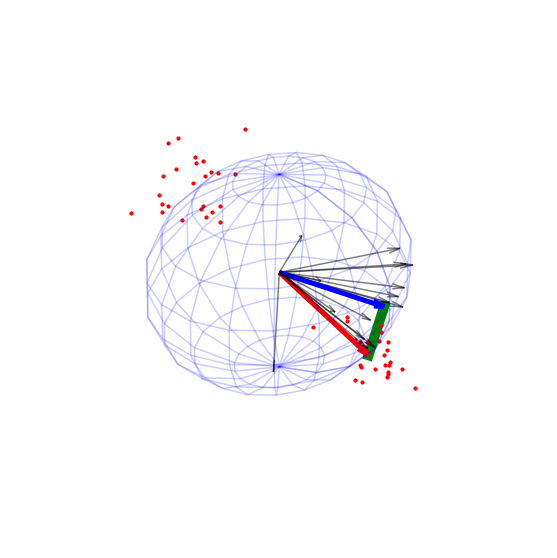

In [115]:
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

tf.random.set_seed(1)
np.random.seed(1)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

# draw sphere
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
ax.plot_wireframe(x, y, z, color="b", alpha=0.2)

target, source = get_directions(3, 15, k=5)
mu=tfld.estimate_mu(source)

for i,v in enumerate(source):
    ax.quiver(0,0,0,v[0],v[1],v[2],length=1.0, arrow_length_ratio=0.1, color='k', alpha=0.5)
    
ax.quiver(0,0,0,target[0],target[1],target[2],length=1.0, lw=5, arrow_length_ratio=0.1, color='r')
ax.quiver(0,0,0,mu[0],mu[1],mu[2],length=1.0, lw=5,arrow_length_ratio=0.1,color='b')

X, y = create_dataset(50, target, c=0.05)

for i,x in enumerate(X):
    ax.scatter(x[0], x[1], x[2], c='r', s=10)

ax.plot([mu[0], target[0]], [mu[1], target[1]], [mu[2], target[2]], c='g', lw=10)

ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_yticks([-1, -0.5, 0, 0.5, 1])
ax.set_zticks([-1, -0.5, 0, 0.5, 1])
# Plot the surface
ax.set_axis_off()




In [64]:
def parameter_experiment(n, d, J, k, cov=None, alpha_grid_size=0.1):
    nu, source_projections = get_directions(d, J, k)
    source_vector = tfld.estimate_mu(source_projections)
    variance_from_source = get_source_std_error(source_projections)
    
    X, y = create_dataset(n, nu, d)
    
    target_vector, threshold, pooled_cov, class_1_mean = train_fld(X, y, cov=cov)    
    alpha_grid = np.arange(0, 1 + alpha_grid_size, step=alpha_grid_size)
    
    if cov is not None:
        pooled_cov = cov
    
    analytical_risks = np.zeros(len(alpha_grid))
    for i, alpha in enumerate(alpha_grid):
        w_alpha = alpha * target_vector + (1-alpha) * source_vector
        Sigma_alpha = (alpha ** 2) * pooled_cov / n + ((1-alpha)**2) * variance_from_source
        
        wa_samples = np.random.multivariate_normal(w_alpha, Sigma_alpha, 100)

        # compute expected risk per alpha analytically
        f = lambda wa_sample : compute_expected_risk(wa_sample, pooled_cov, class_1_mean)

        analytical_risks[i]  = np.mean(np.array(Parallel(n_jobs=-1)(delayed(f)(wa_sample) for wa_sample in wa_samples)))
        
    alpha = alpha_grid[np.argmin(analytical_risks)]
    combined_vector = alpha * target_vector + (1-alpha) * source_vector
    
    X_test, y_test = create_dataset(100000, nu, d)
    
    source_risk = bas(y_test, (X_test @ source_vector < 0).astype(int))
    combined_risk = bas(y_test, (X_test @ combined_vector < 0).astype(int))
    target_risk = bas(y_test, (X_test @ target_vector < 0).astype(int))
        
    results = {}
    results['risks'] = [source_risk, combined_risk, target_risk]
    results['alpha'] = alpha
    
    return results

  0%|                                                                                             | 0/4 [00:00<?, ?it/s]2023-01-11 18:15:50.459361: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-11 18:15:50.463756: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-11 18:15:50.463777: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-11 18:15:50.469176: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from differen

2023-01-11 18:15:50.686406: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-11 18:15:50.687168: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-11 18:15:50.690140: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-11 18:15:50.690942: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic lib

2023-01-11 18:15:50.902821: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-11 18:15:50.902864: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-11 18:15:52.458673: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-11 18:15:52.458718: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-11 18:15:52.458752: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hayden-bci-2): /proc/driver/nvidia/version does not exist
2023-01-11 18:15:52.459177: I tensorflow/core/platform/cpu_featu

2023-01-11 18:15:53.681481: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-11 18:15:53.681699: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-11 18:15:53.681742: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hayden-bci-2): /proc/driver/nvidia/version does not exist
2023-01-11 18:15:53.682110: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-11 18:15:53.695867: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

2023-01-11 18:15:53.918289: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-11 18:15:53.918812: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-11 18:15:53.919109: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hayden-bci-2): /proc/driver/nvidia/version does not exist
2023-01-11 18:15:53.919660: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-11 18:15:53.921346: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

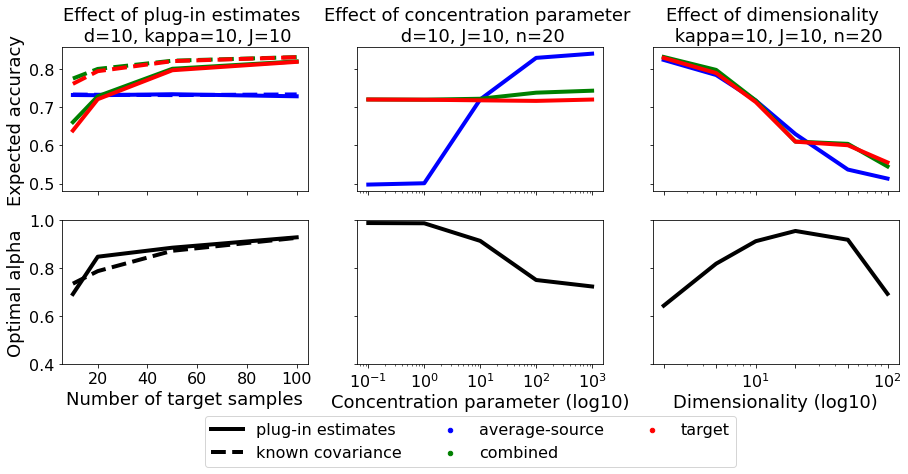

In [73]:

fig, ax = plt.subplots(2,3, figsize=(15,8), sharey='row',sharex='col')

algos = ['average-source', 'combined', 'target']
colors = ['b', 'g', 'r']

# - plot left column

mean_risks = np.mean(risks_cov, axis=0)
for i, algo in enumerate(algos):
    ax[0, 0].plot(n_list, 1- mean_risks[:, 1,i], color=colors[i], lw=4, ls='-')
    ax[0, 0].plot(n_list, 1- mean_risks[:, 0,i], color=colors[i], lw=4, ls='--')

    
mean_alphas = np.mean(alphas_cov, axis=0)        
ax[1,0].plot(n_list, mean_alphas[:, 1], color='k', lw=4, ls='-', label='plug-in estimates')
ax[1,0].plot(n_list, mean_alphas[:, 0], color='k', lw=4, ls='--', label='known covariance')

# - style left column
xlim = ax[1,0].get_xlim()
ylim = ax[1,0].get_ylim()

for i, algo in enumerate(algos):
    ax[1,0].scatter(-1,-1, label=algos[i], color=colors[i], s=20)
    

ax[1,0].set_ylim(*ylim)
ax[1,0].set_xlim(*xlim)

# ax[0,0].legend(fontsize=16, loc='lower right')
ax[1,0].legend(fontsize=16)

ax[1,0].set_xlabel('Number of target samples', fontsize=18)
ax[1,0].tick_params(labelsize=16)

ax[0,0].set_title('Effect of plug-in estimates \n d=%i, kappa=%i, J=%i'%(d, kappa, J), fontsize=18)

# - plot center column

mean_risks = np.mean(risks_kappa, axis=0)
for i, algo in enumerate(algos):
    ax[0, 1].semilogx(kappa_list, 1- mean_risks[:, i], color=colors[i], lw=4, label=algos[i])

mean_alphas = np.mean(alphas_kappa, axis=0)        
ax[1,1].semilogx(kappa_list, mean_alphas, color='k', lw=4)
    

# - style center column

#- #- style top
ax[0,0].set_yticks([0.5, 0.6, 0.7, 0.8])
ax[0,0].set_ylabel('Expected accuracy', fontsize=18)

#- #- style bottom
ax[1,1].set_xticks(kappa_list)
ax[1,1].set_xlabel('Concentration parameter (log10)', fontsize=18)

ax[1,0].set_yticks([0.4,0.6, 0.8,1])
ax[1,0].set_ylabel('Optimal alpha', fontsize=18)

#- #- general
ax[1,1].tick_params(labelsize=16)

ax[0,1].set_title('Effect of concentration parameter \n d=%i, J=%i, n=%i'%(d,J,n), fontsize=18)

# ax[0,1].legend(fontsize=16, loc='lower right')


# - plot right column

mean_risks = np.mean(risks_d, axis=0)
for i, algo in enumerate(algos):
    ax[0, 2].semilogx(d_list, 1- mean_risks[:, i], color=colors[i], lw=4, label=algos[i])

mean_alphas = np.mean(alphas_d, axis=0)        
ax[1,2].semilogx(d_list, mean_alphas, color='k', lw=4)
    

# - style right column

#- #- style top
# ax[0,1].set_ylabel('Expected accuracy', fontsize=18)

ax[1,2].tick_params(labelsize=16)
ax[0,0].tick_params(labelsize=16)

#- #- style bottom
ax[1,2].set_xticks(d_list)

ax[1,2].set_xlabel('Dimensionality (log10)', fontsize=18)

ax[0,2].set_title('Effect of dimensionality \n kappa=%i, J=%i, n=%i'%(kappa, J, n), fontsize=18)

plt.subplots_adjust(bottom=0.3, top=0.85)
ax[1,0].legend(fontsize=16, loc='lower left', ncol=3, bbox_to_anchor=(0.55, -0.77, 0.1, 0.2))

# plt.tight_layout()
# plt.savefig('effect-of-parameters.pdf', bbox_inches="tight")